# Import libraries & data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
customer_df = pd.read_csv('we_fn_use_c_marketing_customer_value_analysis.csv')

# Lab 4.1 - Numerical data cleaning

In [ ]:
# No NaNs values in the dataset

display(customer_df.info()) # or this code for nulls: customer_df.isnull().sum()/len(customer_df). But we can see already w/ info 
display(customer_df.shape)
customer_df.head()

In [ ]:
customer_df.describe().T

In [ ]:
# For loop to replace the column headers with lowercase snake format

n_cols = []
for i in range(len(customer_df.columns)):
    n_cols.append(customer_df.columns[i].lower().replace(' ','_'))

customer_df.columns = n_cols


In [ ]:
# The above code did not fix employmentstatus so I've done this. I'm sure there is a way to do it in the loop with regex...

customer_df = customer_df.rename(columns = {'employmentstatus':'employment_status'})

In [ ]:
# Change effective to date into a datetime format column

customer_df['effective_to_date'] = pd.to_datetime(customer_df['effective_to_date'])

In [ ]:
# To understand the data better (and clean as appropriate), we will start by separating numerical from the categorical

numerical = customer_df.select_dtypes(include=np.number)
categorical = customer_df.select_dtypes(include=object)

In [ ]:
numerical.columns

In [ ]:
numerical.shape[0] # This is the number of rows 

In [ ]:
# In the numerical data, we need to separate the continuous from discrete variables

discrete_lst = []
continuous_lst = []

for col in numerical.columns:
    if len(numerical[col].unique()) < (numerical.shape[0] * 0.02):
        discrete_lst.append(col)
    else:
        continuous_lst.append(col)
display(discrete_lst)
display(continuous_lst)

In [ ]:
# Function to pass the discrete / continuous split to the numerical dataset

def discrete_continuous(df):
    discrete_lst = []
    continuous_lst = []
    for col in numerical.columns:
        if len(numerical[col].unique()) < (numerical.shape[0] * 0.02):
            discrete_lst.append(col)
        else:
            continuous_lst.append(col)
    return (discrete_lst, continuous_lst)

In [ ]:
# Apply the function

discrete_lst, continuous_lst = discrete_continuous(numerical)

In [ ]:
# Plot a correlation matrix
# We see that monthly_premium_auto is moderately correlated with both customer_lifetime_value (0.4) and total_claim_amount (0.63)
# Total_claim_amount has a weak negative correlation with income (-0.36)
# Nothing here would lead us to cut out a column in the numerical data

correlations = numerical.corr()

fig, ax=plt.subplots(figsize=(10,8))
ax=sns.heatmap(correlations, cmap='mako_r', annot=True)
plt.show()

In [ ]:
# Plot the numerical variables to see their skew / distributions
# Note: These four variables could be converted to categoricals but I don't think it's necessary here

for column in numerical[discrete_lst]:
    sns.displot(numerical[column], kde=True)
    plt.show()

In [ ]:
# Plot the categorical variables

for column in numerical[continuous_lst]:
    sns.histplot(numerical[column])
    plt.show()

In [ ]:
# Checking for outliers in the continuous variables

for column in numerical[continuous_lst]:
    sns.boxplot(numerical[column])
    plt.show()

In [ ]:
# Dealing with outliers -- using the IQR and a function to pass it to all variables
# We could also try a log transform (perhaps instead?)

def detect_outlier(column):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(column), [25, 75])
 
    # compute IQR
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in column if x <= lower_bound or x >= upper_bound]
 
    return outliers

In [ ]:
clv_outliers = detect_outlier(numerical['customer_lifetime_value'])
np_outliers = detect_outlier(numerical['number_of_policies'])
mpa_outliers = detect_outlier(numerical['monthly_premium_auto'])

display(len(clv_outliers), len(np_outliers), len(mpa_outliers))

customer_df.shape

# Not sure if we want to strike these outliers as it may cause us to lose a lot of data and they may actually have predictive power
# Instead we will log transform to limit the skew caused by the outliers without throwing them out


# Lab 4.2 - categorical data cleaning

In [ ]:
# Explore the categorical data for anomalies. We already know from above that there are no NaNs to deal with... 

categorical.head()

In [ ]:
categorical['state'].unique()

In [ ]:
# def cntplot_cat(df):
#     for column in categorical.columns:
#         sns.countplot(x=categorical[column])
#         plt.show()
#     return None
   
# cntplot_cat(categorical)

In [ ]:
# Drop the customer variable because it is not helpful for our analysis

categorical = categorical.drop(['customer'], axis = 1)

In [ ]:
categorical_columns = [col for col in categorical if (len(categorical[col].unique()) < (categorical.shape[0] * 0.01))]

In [ ]:
# Fix education -- try to filter it into four categories instead (Note: not sure how college and bachelor differ)

#categorical.loc[categorical["education"].isin(['Master','Doctor'])] = "Graduate" # This is the problem code

collapse = categorical["education"].value_counts().index[:3]

categorical["education"] = np.where(categorical["education"].isin(collapse), categorical["education"], 'Graduate')
categorical["education"].value_counts(dropna=False)

In [ ]:
# Run the same operation for vehicle_type

collapse2 = categorical["vehicle_class"].value_counts().index[:3]
categorical["vehicle_class"] = np.where(categorical["vehicle_class"].isin(collapse2), categorical["vehicle_class"], 'Luxury')
categorical["vehicle_class"].value_counts(dropna=False)

In [ ]:
# Encode 'response' to be 0 or 1 so we can fix the data imbalance later...

def yes_no(x):
    if x=='Yes':
        return 1
    else:
        return 0

categorical['response'] = list(map(yes_no,categorical['response']))

In [ ]:
display(categorical["policy"].value_counts(dropna=False))
categorical["policy_type"].value_counts(dropna=False)

In [ ]:
# Given the similarity of policy and policy_type, we can remove policy altogether (and maybe drop Special Auto as well)

categorical = categorical.drop(['policy'], axis = 1)

In [ ]:
# This is out final output for categorical variables:
 
categorical

# Lab 4.3 - Feature extraction

In [ ]:
# I've already cleaned the categorical data to my liking above. See results:

def cntplot_cat(df):
    for column in categorical.columns:
        sns.countplot(x=categorical[column])
        plt.show()
    return None
   
cntplot_cat(categorical)

In [ ]:
customer_df['effective_to_date']

In [ ]:
customer_df.describe().T

In [ ]:
sns.histplot(customer_df['effective_to_date'])
plt.xticks(rotation=70)
plt.show()

# With the histogram plot we see the frequency of policy expirations by date in the first quarter of 2011
# There may be a bi-weekly 'seasonality' so the renewal of insurance may come around recieving the paycheck?

In [ ]:
sns.histplot(customer_df['months_since_policy_inception'])
plt.xticks(rotation=70)
plt.show()

# Doesn't look like there are any links between 'effective_to_date' and months since policy inception
# if we map these plots on top of each other (they have different scales anyway)

# Lab 4.5 - Comparing Regression Models

In [227]:
# First we need to rejoin our pre-processed categorical and numerical data (from above) together

data = pd.concat((numerical,categorical),axis=1)

data.head().T

# We are not removing outliers in the numericals at this point

# Instead, we are electing to log transform them instead (and keep some of their explanatory power)

,0,1,2,3,4
customer_lifetime_value,2763.519279,6979.535903,12887.43165,7645.861827,2813.692575
income,56274,0,48767,0,43836
monthly_premium_auto,69,94,108,106,73
months_since_last_claim,32,13,18,18,12
months_since_policy_inception,5,42,38,65,44
number_of_open_complaints,0,0,0,0,0
number_of_policies,1,8,2,7,1
total_claim_amount,384.811147,1131.464935,566.472247,529.881344,138.130879
state,Washington,Arizona,Nevada,California,Washington
response,0,0,0,0,0


In [228]:
X = data.drop(['total_claim_amount'],axis=1)
y = data['total_claim_amount']

In [229]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [231]:
# Numericals

# Split into test / train

X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)
X_train_num.head().T

,3715,3824,4708,8734,6094
customer_lifetime_value,9015.915395,9672.701942,9061.767848,14980.04626,8229.240991
income,0.000000,0.000000,37970.000000,0.00000,0.000000
monthly_premium_auto,130.000000,96.000000,115.000000,222.00000,109.000000
months_since_last_claim,32.000000,5.000000,8.000000,26.00000,5.000000
months_since_policy_inception,38.000000,27.000000,44.000000,50.00000,63.000000
number_of_open_complaints,0.000000,0.000000,0.000000,0.00000,0.000000
number_of_policies,4.000000,2.000000,3.000000,8.00000,3.000000
response,0.000000,0.000000,0.000000,0.00000,0.000000


In [232]:
# A function to apply to those columns we would like to log transform

def log_transform(x):
    x = np.log10(x)
    if np.isfinite(x):
        return x
    else:
        return 0

In [233]:
# Applying the log transform function to the three numerical columns that require it most (based on the displots above)
# All of the other columns in the numericals should be fine as they are

X_train_num['monthly_premium_auto'] = X_train_num['monthly_premium_auto'].apply(log_transform)
X_train_num['income'] = X_train_num['income'].apply(log_transform)
X_train_num['customer_lifetime_value'] = X_train_num['customer_lifetime_value'].apply(log_transform)

X_test_num['monthly_premium_auto'] = X_test_num['monthly_premium_auto'].apply(log_transform)
X_test_num['income'] = X_test_num['income'].apply(log_transform)
X_test_num['customer_lifetime_value'] = X_test_num['customer_lifetime_value'].apply(log_transform)

In [234]:
# Categoricals

# Split the test and training data for the categoricals

X_train_cat = X_train.select_dtypes(object)
X_test_cat = X_test.select_dtypes(object)

# I used this to check all of the unique values by variable and set up the prefered ordinals below

X_train_cat['education'].value_counts()

Bachelor                1682
College                 1617
High School or Below    1533
Graduate                 648
Name: education, dtype: int64

In [235]:
# Converting some variables to ordinal instead of OneHot encoding them 
# The goal is to make all the dummy variables between 0 and 1
# I know some loops / functions would be better here but I ran out of time to figure it out

X_train_cat["coverage"] = X_train_cat["coverage"].map({"Basic" : 0, "Extended" : 0.5, "Premium" : 1})
X_train_cat['employment_status'] = X_train_cat['employment_status'].map({'Unemployed': 0, 'Employed': 0.25, 'Medical Leave': 0.5, 'Disabled': 0.75, 'Retired': 1})
X_train_cat["vehicle_size"] = X_train_cat["vehicle_size"].map({"Small" : 0, "Medsize" : 0.5, "Large" : 1})
X_train_cat["location_code"] = X_train_cat["location_code"].map({"Suburban" : 0, "Rural" : 0.5, "Urban" : 1})
X_train_cat["education"] = X_train_cat["education"].map({"Bachelor" : 0, "College" : 0.33, "High School or Below" : 0.67, 'Graduate': 1})
X_train_cat['state'] = X_train_cat['state'].map({"California" : 0, "Oregon" : 0.25, "Arizona" : 0.5, 'Nevada': 0.75, 'Washington': 1})

X_train_OneHot = X_train_cat.drop(["coverage",'employment_status',"vehicle_size","location_code","education", 'state'], axis=1)
X_train_ordinal = X_train_cat[["coverage",'employment_status',"vehicle_size","location_code","education", 'state']]

In [236]:
X_test_cat["coverage"] = X_test_cat["coverage"].map({"Basic" : 0, "Extended" : 0.5, "Premium" : 1})
X_test_cat['employment_status'] = X_test_cat['employment_status'].map({'Unemployed': 0, 'Employed': 0.25, 'Medical Leave': 0.5, 'Disabled': 0.75, 'Retired': 1})
X_test_cat["vehicle_size"] = X_test_cat["vehicle_size"].map({"Small" : 0, "Medsize" : 0.5, "Large" : 1})
X_test_cat["location_code"] = X_test_cat["location_code"].map({"Suburban" : 0, "Rural" : 0.5, "Urban" : 1})
X_test_cat["education"] = X_test_cat["education"].map({"Bachelor" : 0, "College" : 0.33, "High School or Below" : 0.67, 'Graduate': 1})
X_test_cat['state'] = X_test_cat['state'].map({"California" : 0, "Oregon" : 0.25, "Arizona" : 0.5, 'Nevada': 0.75, 'Washington': 1})

X_test_OneHot = X_test_cat.drop(["coverage",'employment_status',"vehicle_size","location_code","education", 'state'], axis=1)
X_test_ordinal = X_test_cat[["coverage",'employment_status',"vehicle_size","location_code","education", 'state']]

In [237]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(X_train_OneHot)
X_train_encoded = encoder.transform(X_train_OneHot).toarray()
X_test_encoded = encoder.transform(X_test_OneHot).toarray()

In [238]:
# Concatenate the ordinal and encoded categorical variables

X_train_cat_concat = np.concatenate((X_train_ordinal, X_train_encoded),axis=1)
X_test_cat_concat = np.concatenate((X_test_ordinal, X_test_encoded),axis=1)

In [239]:
# Concatenate the transformed numericals with the encoded and ordinal categoricals.
# Ready to fit the model

X_train_processed = np.concatenate((X_train_num, X_train_cat_concat), axis=1)
X_test_processed = np.concatenate((X_test_num, X_test_cat_concat), axis=1)

In [240]:
display(pd.DataFrame(X_test_processed))
display(pd.DataFrame(X_train_processed))

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,3.708639,4.752717,1.812913,4.0,88.0,1.0,6.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3.688623,4.327073,2.089905,3.0,12.0,0.0,1.0,0.0,0.5,0.25,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3.739488,4.529956,1.832509,11.0,83.0,0.0,9.0,0.0,0.0,0.25,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.568247,4.244450,1.982271,6.0,5.0,0.0,1.0,0.0,0.5,1.00,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.938512,4.721951,2.037426,5.0,60.0,0.0,8.0,0.0,1.0,0.25,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,3.706463,0.000000,1.857332,12.0,70.0,0.0,3.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3650,4.331141,4.315298,2.274158,34.0,54.0,3.0,2.0,0.0,0.0,0.25,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3651,3.945020,4.882331,2.041393,24.0,88.0,1.0,3.0,0.0,1.0,0.25,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3652,3.620956,4.149465,2.037426,27.0,88.0,0.0,1.0,0.0,1.0,0.50,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,3.955010,0.000000,2.113943,32.0,38.0,0.0,4.0,0.0,0.5,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.985548,0.000000,1.982271,5.0,27.0,0.0,2.0,0.0,0.5,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.957213,4.579441,2.060698,8.0,44.0,0.0,3.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.175513,0.000000,2.346353,26.0,50.0,0.0,8.0,0.0,0.5,0.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,3.915360,0.000000,2.037426,5.0,63.0,0.0,3.0,0.0,0.0,0.00,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,3.890007,4.377069,2.025306,18.0,77.0,2.0,3.0,0.0,1.0,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5476,4.764673,4.787609,2.269513,0.0,30.0,1.0,2.0,0.0,0.0,0.25,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5477,3.746453,4.045206,1.863323,26.0,50.0,0.0,4.0,0.0,0.0,0.75,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5478,3.610948,4.365600,2.029384,31.0,60.0,0.0,1.0,0.0,0.0,0.50,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [241]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [242]:
# I cut some corners by borrowing Erin's code (thanks, Erin). The results are mixed...

def models_function(models, X_train_m, y_train_m, X_test_m, y_test_m):
    for model in models:
        model.fit(X_train_m, y_train_m)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_train_m, y_train_m)}, Test -> {model.score(X_test_m, y_test_m)}")

In [243]:
lm = LinearRegression()

knn = KNeighborsRegressor(n_neighbors=6)

mlp = MLPRegressor()

In [244]:
model_list = [lm, knn, mlp]
models_function(model_list, X_train_processed, y_train, X_test_processed, y_test)

LinearRegression: Train -> 0.6125964151507608, Test -> 0.586464808722574
KNeighborsRegressor: Train -> 0.373385679648381, Test -> 0.07778473562827759
MLPRegressor: Train -> 0.6031036913987439, Test -> 0.5860318687358297


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# ...Not sure what happened with the KNN model above. The results seem anomalous as though something is not correct.
# Otherwise we see the strongest predictor may actually be the linear model with the highest R2 scores by a small margin.

In [245]:
knn_pred = knn.predict(X_test_processed)[:3]

lm_pred = lm.predict(X_test_processed)[:3]

mlp_pred = mlp.predict(X_test_processed)[:3]

print(y_test[:3]) 
print(knn_pred)
print(lm_pred)
print(mlp_pred)

# Based on predicted values, we see a lot of variance between the models


7175    312.000000
7255    131.262395
2846     65.659137
Name: total_claim_amount, dtype: float64
[215.3213065  431.91295683 399.16727417]
[245.07147077 476.65699444 165.69323622]
[299.15621265 489.11140504 207.53297838]


# Lab 4.6 - Random Variable Distributions

In [249]:
# 1. Get the numerical variables from our dataset.

numerical.head().T


,0,1,2,3,4
customer_lifetime_value,2763.519279,6979.535903,12887.431650,7645.861827,2813.692575
income,56274.000000,0.000000,48767.000000,0.000000,43836.000000
monthly_premium_auto,69.000000,94.000000,108.000000,106.000000,73.000000
months_since_last_claim,32.000000,13.000000,18.000000,18.000000,12.000000
months_since_policy_inception,5.000000,42.000000,38.000000,65.000000,44.000000
number_of_open_complaints,0.000000,0.000000,0.000000,0.000000,0.000000
number_of_policies,1.000000,8.000000,2.000000,7.000000,1.000000
total_claim_amount,384.811147,1131.464935,566.472247,529.881344,138.130879


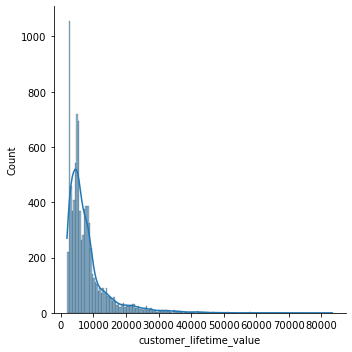

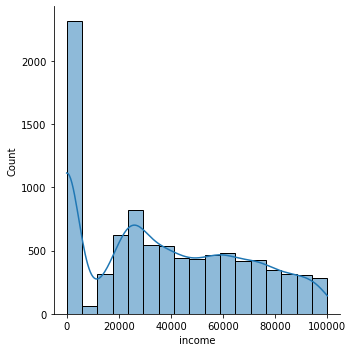

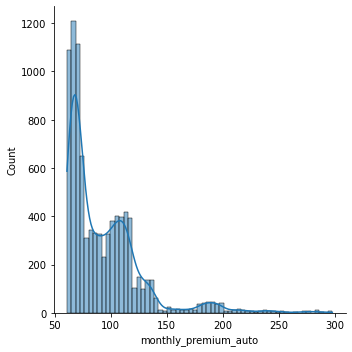

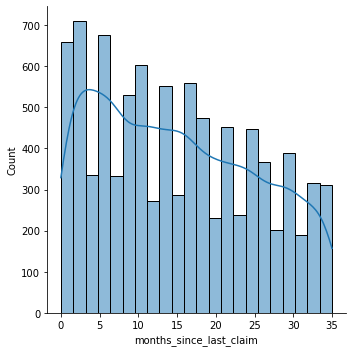

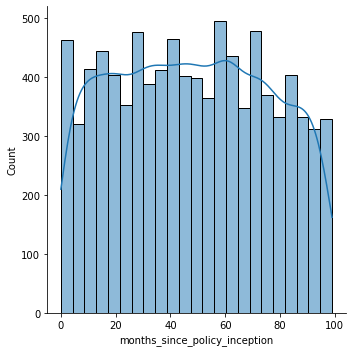

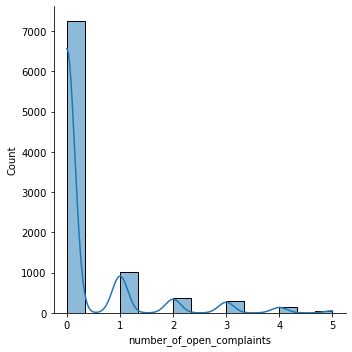

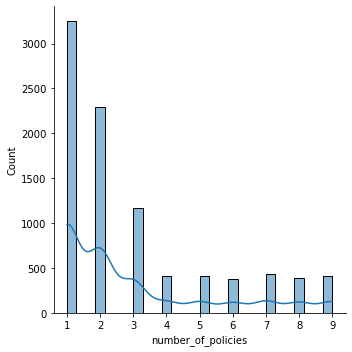

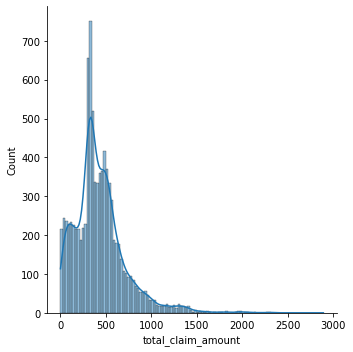

In [250]:
# 2. Check using a distribution plot if the variables fit the theoretical normal or exponential distribution.

for column in numerical:
    sns.displot(numerical[column], kde=True)
    plt.show()

# Based on the plots below, the variables that appear to have normal distributions are:
    # income
    # months_since_last_claim
    # months_since_policy_inception

# The exponential distributions are:
    # customer_lifetime_value
    # monthly_premium_auto
    # total_claim_amount (note: this is the target)

# number_of_open_complaints and number_of_policies resemble ordinal categoricals 
# as opposed to continuous random variables so their distributions are not great, but they exhibit a right skew



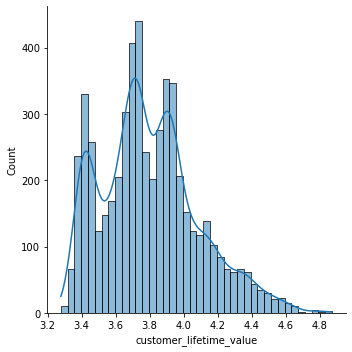

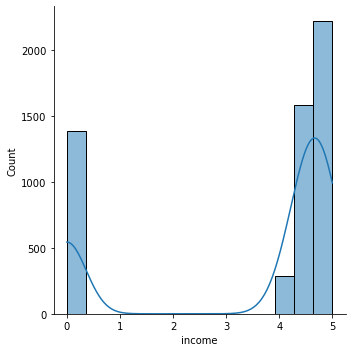

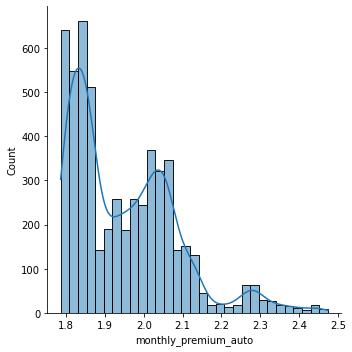

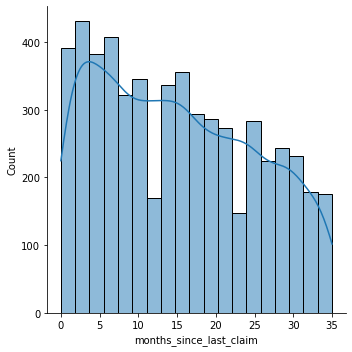

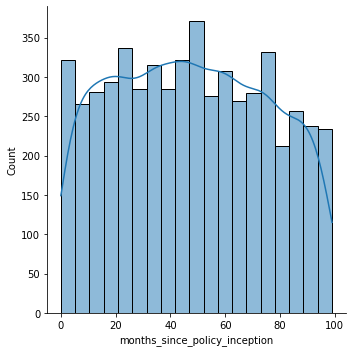

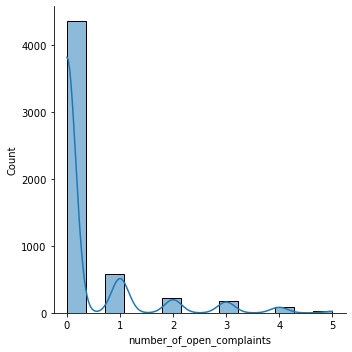

In [251]:
# 3. Check if any of the transformations (log-transform, etc.) we have seen up to this point changes the result.

for column in X_train_num:
    sns.displot(X_train_num[column], kde=True)
    plt.show()

# When we log transform the first three numericals (and drop the target), 'customer_lifetime_value' and 'monthly_premium_auto' start to look more normal...
# ...Whereas 'income' starts to look bimodal
# So it is clear that log transform changed the shape of the distribution for those variables (by limiting the effect of outliers)

# As a side note: 'response' looks bimodal (yes / no) and may actually belong in the categorical variables...